# Initial EDA for Senior Thesis

## Dependencies

In [1]:
# libraries that I may potential need:
import pandas as pd
import math
import time
import os
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import rasterio.warp
from rasterio.windows import from_bounds
from rasterio.warp import transform_bounds
import geopandas as gpd
from shapely.geometry import Point, box
from pandas.plotting import scatter_matrix
import random
import seaborn as sns

## Variables

### Used Google Translate to reencocde variable names:
| original variable name | translated variable name |
| --- |--- |
| gattung_botanisch  | botanical genus     |
| gattung_deutsch    | German genus        |
| art_botanisch      | botanical species   |
| art_deutsch        | German species      |
| alleebaum          | avenue tree         |
| hoehe              | height              |
| stammdurchmesser   | trunk diameter      |
| stammumfang        | trunk circumference |
| kronendurchmesser  | crown diameter      |
| baumpatenschaft    | tree sponsorship    |

In [2]:
# set path to data set
path = '../data/data_gov_de/trees/baeume.json'

# create german to english variable name map
recoded_column_names = {
    'gattung_botanisch' : 'botanical_genus'     ,
    'gattung_deutsch'   : 'German_genus'        ,
    'art_botanisch'     : 'botanical_species'   ,
    'art_deutsch'       : 'German-species'      ,
    'alleebaum'         : 'avenue_tree'         ,
    'hoehe'             : 'height'              ,
    'stammdurchmesser'  : 'trunk_diameter'      ,
    'stammumfang'       : 'trunk_circumference' ,
    'kronendurchmesser' : 'crown_diameter'      ,
    'baumpatenschaft'   : 'tree_sponsorship'    ,
    }

## Functions

In [3]:
def list_printer(a_list:list, number_of_items_to_print:int = 10000, span:int=80):
    """
    # Formated list printer
    ## Expects: 
     - A list like object
     - number of items from list to print. Default 10000
     - max length of page in. Assumes terminal is using fixed width font. Default 80
    ## Returns: Prints a formated list.
    """
    counter = 1
    list_len = len(a_list)
    max_len = len(max(a_list, key=len)) + 2
    if span > max_len:
        cols = round(span / max_len )
    else: return f'span {span} must be greater than len of longest item in list {max_len} +2'
    for i in a_list:
        if counter > number_of_items_to_print:
            break
        elif counter % cols == 0:
            print(f'{i:^{max_len}}')
        else: 
            print(f'{i:^{max_len}}', end= ' | ')
        counter += 1

def round_to_nearest_n(x, base):
    """
    Rounds a value to the nearest multiple of 'base'.
    """
    return base * round(x / base)

## Load and Inspect data

In [4]:
# read GeoJson data into a GeoPandas DF
gdf = gpd.read_file(path, encoding='utf-8')

# map translated variable names
gdf = gdf.rename(columns=recoded_column_names)
gdf.head()

# inspect head
gdf.head()

,uuid,botanical_genus,German_genus,botanical_species,German-species,avenue_tree,height,trunk_diameter,trunk_circumference,crown_diameter,tree_sponsorship,geometry
0,fa3c43ce-8e5f-46e6-ac9d-aa950bf0f4a9,Acer,Ahorn,Acer species,Ahorn,False,10.0,20.37,64.0,5.0,False,POINT (12.11649 54.06367)
1,1140029d-8c75-47c4-ace0-19ac0ed66410,Acer,Ahorn,Acer species,Ahorn,False,14.0,42.65,134.0,10.0,False,POINT (12.04897 54.14658)
2,67e8b1df-0c5a-48b8-bd86-a8b5c126f6e3,Acer,Ahorn,Acer species,Ahorn,False,12.0,28.97,91.0,7.0,False,POINT (12.04912 54.14656)
3,b3663402-c4c7-49f0-9c9e-79f01f5c378a,Acer,Ahorn,Acer species,Ahorn,False,9.0,37.24,117.0,9.0,False,POINT (12.04819 54.14642)
4,09981ce2-fcc4-48c7-a390-8c2135071f00,Prunus,Kirsche,Prunus species,Kirsche,False,8.0,32.79,103.0,7.0,False,POINT (12.0475 54.14627)


In [5]:
# summarize
gdf.describe()

,height,trunk_diameter,trunk_circumference,crown_diameter
count,69485.000000,69327.000000,69327.000000,69391.000000
mean,12.725637,34.108017,107.153498,6.631641
std,8.557337,24.995161,78.524687,4.955328
min,0.500000,0.250000,0.800000,0.100000
25%,7.000000,18.140000,57.000000,4.000000
50%,11.000000,29.920000,94.000000,6.000000
75%,17.000000,44.880000,141.000000,9.000000
max,915.000000,2588.000000,8130.440000,812.000000


In [6]:
# check for indications of missing data.
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 70606 entries, 0 to 70605
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   uuid                 70606 non-null  object  
 1   botanical_genus      70606 non-null  object  
 2   German_genus         70606 non-null  object  
 3   botanical_species    70606 non-null  object  
 4   German-species       70606 non-null  object  
 5   avenue_tree          70606 non-null  bool    
 6   height               69485 non-null  float64 
 7   trunk_diameter       69327 non-null  float64 
 8   trunk_circumference  69327 non-null  float64 
 9   crown_diameter       69391 non-null  float64 
 10  tree_sponsorship     70606 non-null  bool    
 11  geometry             70606 non-null  geometry
dtypes: bool(2), float64(4), geometry(1), object(5)
memory usage: 5.5+ MB


In [7]:
# collect unique genuses
genus = gdf['botanical_genus'].unique().tolist()
list_printer(genus, number_of_items_to_print=20, span=150)

      Acer       |      Prunus      |      Betula      |      Ulmus       |      Salix       |      Sorbus      |      Pinus       |      Picea       |     Fraxinus    
     Tilia       |     Species      |      Malus       |   Gruppenbäume   |     Viburnum     |     Populus      |     Quercus      |     Carpinus     |      Abies      
     Pyrus       |      Fagus       | 

In [8]:
# collect unique species
species = gdf['botanical_species'].unique().tolist()
list_printer(species, number_of_items_to_print=10, span=150)

                 Acer species                   |                 Prunus species                  |                 Betula species                 
                Betula pendula                  |               Ulmus carpinifolia                |                 Acer campestre                 
              Acer pseudoplatanus               |                Prunus cerasifera                |                  Salix caprea                  
               Sorbus intermedia                | 

In [9]:
# remove common name from species variable and create two new features
# - botanical_species_formal_name
# - botanical_species_common_name
gdf[['botanical_species_formal_name', 'botanical_species_common_name']] = gdf['botanical_species'].str.split(' „', expand=True).fillna(pd.NA)
gdf['botanical_species_common_name'] = gdf['botanical_species_common_name'].str.replace('“', '')

In [10]:
# create mask for botanical_species_formal_name containing the string 'species'
# we are isolating units where a generalization from a species to a genus was made.
mask_botanical_species_formal_name = gdf['botanical_species_formal_name'].str.contains('species')
# set masked recs to NA
gdf.loc[mask_botanical_species_formal_name, 'botanical_species_formal_name'] = pd.NA
# aint-subset units whose species has been generalized to a genus to a list
species = gdf['botanical_species_formal_name'][~mask_botanical_species_formal_name].unique().tolist()
list_printer(species, number_of_items_to_print=30, span=150)

            Betula pendula             |           Ulmus carpinifolia           |             Acer campestre             |          Acer pseudoplatanus          
          Prunus cerasifera            |              Salix caprea              |           Sorbus intermedia            |            Pinus sylvestris           
             Picea abies               |           Fraxinus excelsior           |           Tilia platyphyllos           |            Acer platanoides           
            Fraxinus ornus             |  Verschiedene oder Baumart unbekannt   |        Ahorn-Laub-Mischbestand         |             Tilia cordata             
       Viburnum rhytidophyllum         |             Populus nigra              |            Tilia x euchlora            |             Quercus robur             
          Abies nordmanniana           |                 Malus                  |            Pyrus calleryana            |            Tilia tomentosa            
           Fagus sylvatica  

In [11]:
gdf

,uuid,botanical_genus,German_genus,botanical_species,German-species,avenue_tree,height,trunk_diameter,trunk_circumference,crown_diameter,tree_sponsorship,geometry,botanical_species_formal_name,botanical_species_common_name
0,fa3c43ce-8e5f-46e6-ac9d-aa950bf0f4a9,Acer,Ahorn,Acer species,Ahorn,False,10.0,20.37,64.00,5.0,False,POINT (12.11649 54.06367),<NA>,<NA>
1,1140029d-8c75-47c4-ace0-19ac0ed66410,Acer,Ahorn,Acer species,Ahorn,False,14.0,42.65,134.00,10.0,False,POINT (12.04897 54.14658),<NA>,<NA>
2,67e8b1df-0c5a-48b8-bd86-a8b5c126f6e3,Acer,Ahorn,Acer species,Ahorn,False,12.0,28.97,91.00,7.0,False,POINT (12.04912 54.14656),<NA>,<NA>
3,b3663402-c4c7-49f0-9c9e-79f01f5c378a,Acer,Ahorn,Acer species,Ahorn,False,9.0,37.24,117.00,9.0,False,POINT (12.04819 54.14642),<NA>,<NA>
4,09981ce2-fcc4-48c7-a390-8c2135071f00,Prunus,Kirsche,Prunus species,Kirsche,False,8.0,32.79,103.00,7.0,False,POINT (12.0475 54.14627),<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70601,97c54563-ba82-458f-aab3-0916e99233ed,Tilia,Linde,Tilia tomentosa „Brabant“,Silber-Linde „Brabant“,False,2.0,11.14,35.00,1.0,False,POINT (12.09179 54.08617),Tilia tomentosa,Brabant
70602,c6aa997b-17b5-4ac0-a29f-f2745997c654,Salix,Weide,Salix alba „Tristis“,Trauer-Weide „Tristis“,False,8.0,17.00,53.41,5.0,False,POINT (12.14481 54.08689),Salix alba,Tristis
70603,50cfdee3-d244-4026-a7d0-99a93bf18e6c,Prunus,Kirsche,Prunus padus „Schloss Tiefurt“,Trauben-Kirsche „Schloss Tiefurt“,False,7.0,14.32,45.00,1.0,False,POINT (12.11341 54.08167),Prunus padus,Schloss Tiefurt
70604,8323b378-921b-42a4-a40d-586b23d23897,Prunus,Kirsche,Prunus padus „Schloss Tiefurt“,Trauben-Kirsche „Schloss Tiefurt“,False,6.0,7.96,25.00,1.0,False,POINT (12.11348 54.08165),Prunus padus,Schloss Tiefurt


<Axes: >

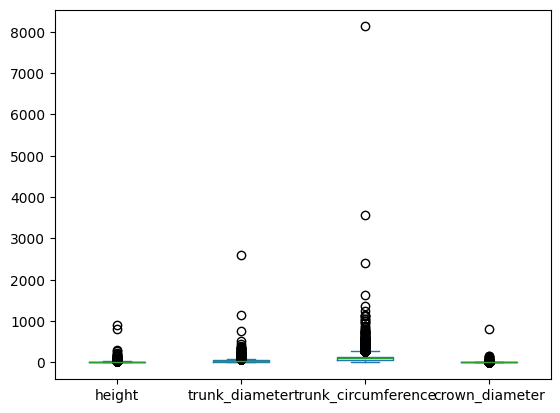

In [12]:
# look for evidence of outliers
gdf[['height','trunk_diameter','trunk_circumference','crown_diameter']].plot.box()

In [13]:
# set SD limit
numsd = 3

<Axes: ylabel='Frequency'>

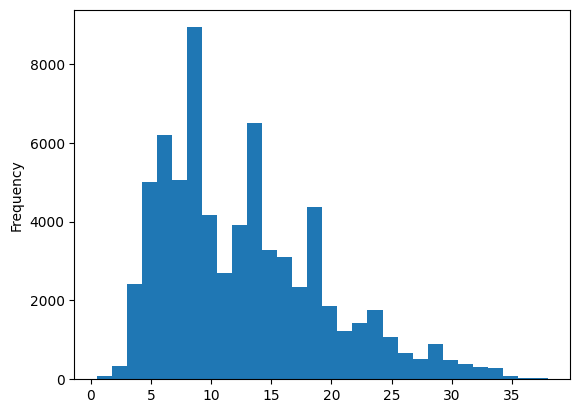

In [14]:
# we subset by trees whose height within four standard deviations of the mean height
# Note: The tallest tree in Germany is about 68 meters.
# Trees taller than that are excluded.
smpsd = gdf['height'].std()
smpmean = gdf['height'].mean()
limit = smpmean+(smpsd*numsd)
mask_height = gdf['height'] <= limit
gdf['height'][mask_height].plot.hist(bins=30)

<Axes: ylabel='Frequency'>

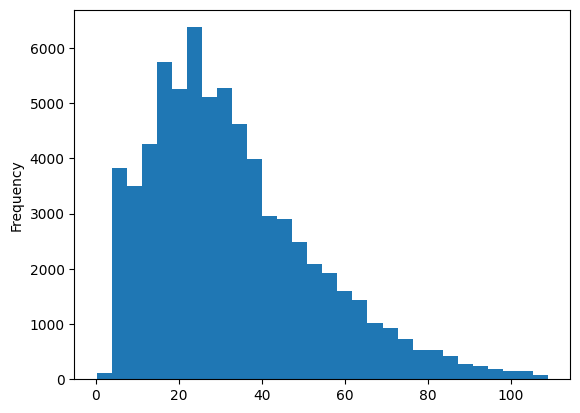

In [15]:
# we subset by trees whose trunk_diameter is within four standard deviations of the mean trunk_diameter
smpsd = gdf['trunk_diameter'].std()
smpmean = gdf['trunk_diameter'].mean()
limit = smpmean+(smpsd*numsd)
mask_trunk_diameter = gdf['trunk_diameter'] <= limit
gdf['trunk_diameter'][mask_trunk_diameter].plot.hist(bins=30)

<Axes: ylabel='Frequency'>

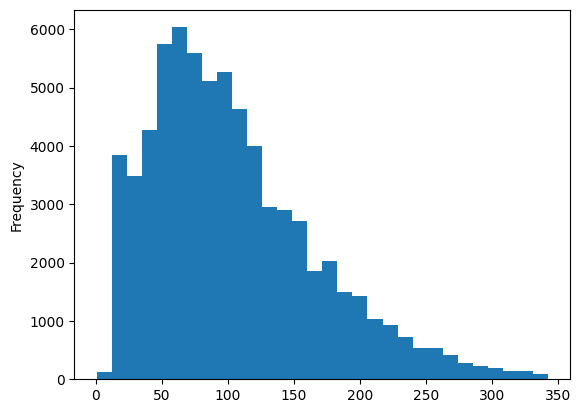

In [16]:
# we subset by trees whose trunk_circumference is within four standard deviations of the mean trunk_circumference
smpsd = gdf['trunk_circumference'].std()
smpmean = gdf['trunk_circumference'].mean()
limit = smpmean+(smpsd*numsd)
mask_trunk_circumference = gdf['trunk_circumference'] <= limit
gdf['trunk_circumference'][mask_trunk_circumference].plot.hist(bins=30)

<Axes: ylabel='Frequency'>

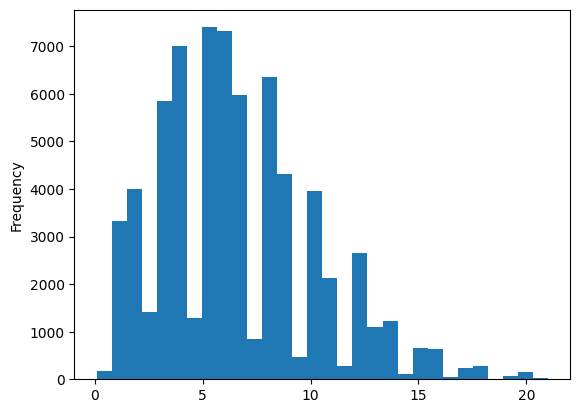

In [17]:
# we subset by trees whose crown_diameter is within four standard deviations of the mean crown_diameter
smpsd = gdf['crown_diameter'].std()
smpmean = gdf['crown_diameter'].mean()
limit = smpmean+(smpsd*numsd)
mask_crown_diameter = gdf['crown_diameter'] <= limit
gdf['crown_diameter'][mask_crown_diameter].plot.hist(bins=30)

<Axes: >

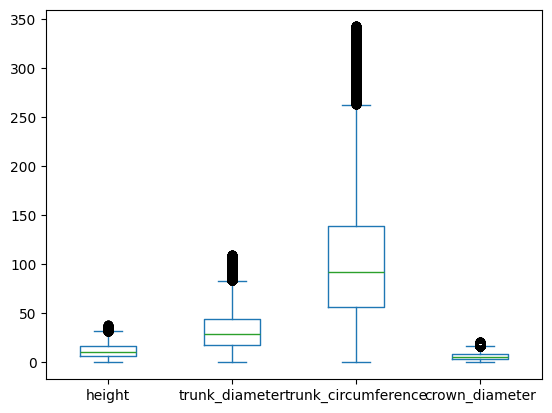

In [18]:
# generate a uniform mask that excludes outliers across all continuious variables
# Note: we do not drop these units, as these are still trees and may contribute to a future competitive density feature
mask_non_outlier = mask_height & mask_trunk_diameter & mask_trunk_circumference & mask_crown_diameter
gdf.loc[mask_non_outlier,['height','trunk_diameter','trunk_circumference','crown_diameter']].plot.box()

In [19]:
# isolate cohorts for analysis that are not outliers and have less than n units 
min_count = 50
# counts by species of non outliers.
non_outlier_counts = gdf[mask_non_outlier].groupby('botanical_species_formal_name')['botanical_species_formal_name'].count()

In [20]:
# list of cohorts that meet minimum representation
valid_species = non_outlier_counts[non_outlier_counts > min_count].index.to_list()
list_printer(valid_species)

            Abies grandis             |            Acer campestre            
            Acer negundo              |           Acer platanoides           
         Acer pseudoplatanus          |              Acer rubrum             
          Acer saccharinum            |        Aesculus hippocastanum        
          Aesculus x carnea           |        Ahorn-Laub-Mischbestand       
         Ailanthus altissima          |            Alnus glutinosa           
            Alnus incana              |            Betula pendula            
            Betula utilis             |        Buchen-Eichen-Mischwald       
          Carpinus betulus            |            Castanea sativa           
      Chamaecyparis lawsoniana        |            Corylus colurna           
         Crataegus laevigata          |          Crataegus lavallei          
         Crataegus monogyna           |            Fagus sylvatica           
         Fraxinus excelsior           |            Fraxinus ornu

In [21]:
# mark those records whoes species cohort meets minimum representation...
gdf['qualified_species_representation'] = gdf['botanical_species_formal_name'].isin(valid_species)
# ... and that do not contain outliers.
gdf['in_qualified_cohort'] = gdf['botanical_species_formal_name'].isin(valid_species) & mask_non_outlier
# describe subset
gdf[gdf['in_qualified_cohort']].describe()

,height,trunk_diameter,trunk_circumference,crown_diameter
count,53777.000000,53777.000000,53777.000000,53777.000000
mean,12.424886,32.873602,103.275459,6.464168
std,6.379131,19.407620,60.970927,3.555929
min,0.500000,0.270000,0.850000,0.100000
25%,7.000000,18.000000,56.550000,4.000000
50%,11.000000,29.280000,92.000000,6.000000
75%,16.000000,44.000000,138.230000,8.900000
max,38.000000,109.000000,342.430000,21.000000


<Axes: >

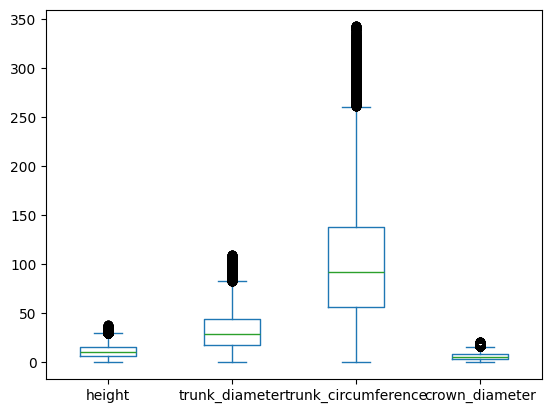

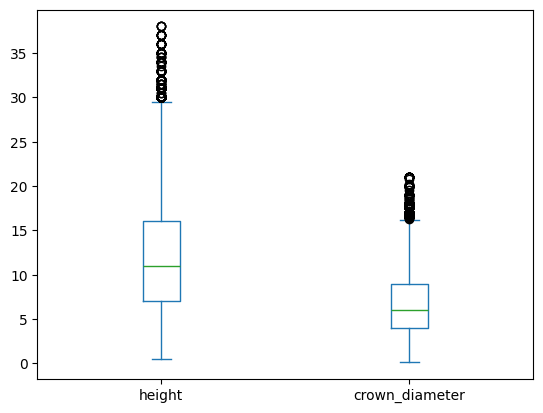

In [22]:
# reexamine key variables in qualified subset
gdf[['height','trunk_diameter','trunk_circumference','crown_diameter']][gdf['in_qualified_cohort']].plot.box()
gdf[['height','crown_diameter']][gdf['in_qualified_cohort']].plot.box()

array([[<Axes: xlabel='height', ylabel='height'>,
        <Axes: xlabel='trunk_diameter', ylabel='height'>,
        <Axes: xlabel='trunk_circumference', ylabel='height'>,
        <Axes: xlabel='crown_diameter', ylabel='height'>],
       [<Axes: xlabel='height', ylabel='trunk_diameter'>,
        <Axes: xlabel='trunk_diameter', ylabel='trunk_diameter'>,
        <Axes: xlabel='trunk_circumference', ylabel='trunk_diameter'>,
        <Axes: xlabel='crown_diameter', ylabel='trunk_diameter'>],
       [<Axes: xlabel='height', ylabel='trunk_circumference'>,
        <Axes: xlabel='trunk_diameter', ylabel='trunk_circumference'>,
        <Axes: xlabel='trunk_circumference', ylabel='trunk_circumference'>,
        <Axes: xlabel='crown_diameter', ylabel='trunk_circumference'>],
       [<Axes: xlabel='height', ylabel='crown_diameter'>,
        <Axes: xlabel='trunk_diameter', ylabel='crown_diameter'>,
        <Axes: xlabel='trunk_circumference', ylabel='crown_diameter'>,
        <Axes: xlabel='crown_di

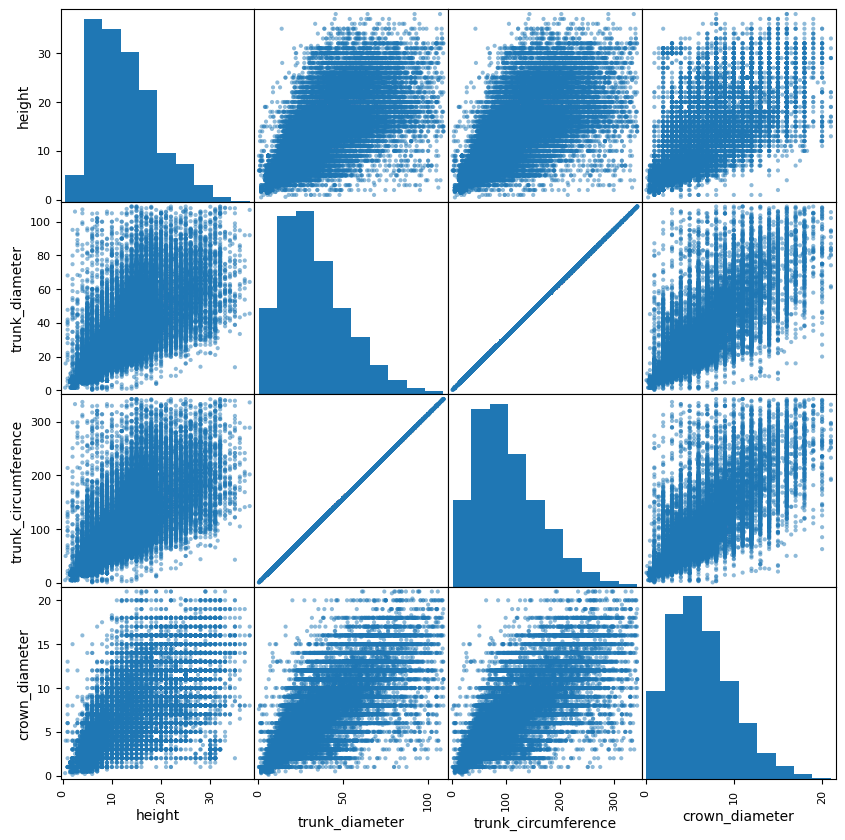

In [23]:
# matrix plot of qualified subset
data_subset = gdf[['height','trunk_diameter','trunk_circumference','crown_diameter']][gdf['in_qualified_cohort']]
scatter_matrix(data_subset, figsize=(10,10),)

<Axes: ylabel='Frequency'>

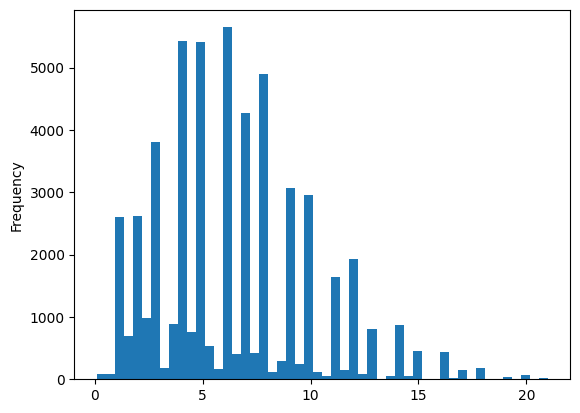

In [24]:
# reexamine the non uniform distribution seen before qalified subsetting
gdf['crown_diameter'][gdf['in_qualified_cohort']].plot.hist(bins=50)

In [25]:
# We see methodological inconsisitency.
# The majority of the observations are rounded to the nearest whole number. But not all.
# We must work around this methodological gap
# Evidience

crown_diameter =       gdf[gdf['in_qualified_cohort']].groupby('crown_diameter')['crown_diameter'].count().index.to_list()
crown_diameter_count = gdf[gdf['in_qualified_cohort']].groupby('crown_diameter')['crown_diameter'].count().to_list()
# for i in range(len(crown_diameter_count)):
#     print(f'crown_diameter {crown_diameter[i]:<5} →   count {crown_diameter_count[i]:<10}')


<Axes: ylabel='Frequency'>

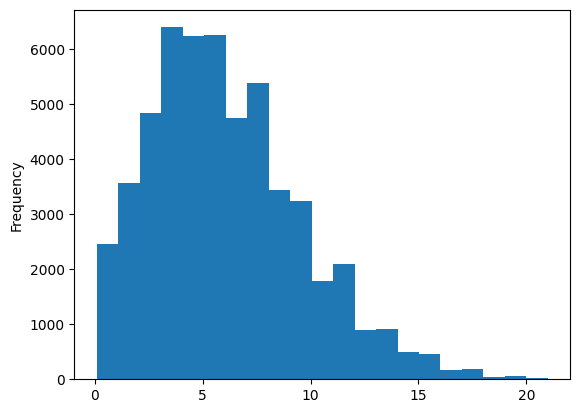

In [26]:
# When adjusting bins to match range of whole numbers, inconsitencies are accounted.
# This will factor into the irreducible error of estimates.
whole_bins = round(gdf['crown_diameter'][gdf['in_qualified_cohort']].max())
gdf['crown_diameter'][gdf['in_qualified_cohort']].plot.hist(bins=whole_bins)

In [27]:
# We assume that this methodological inconsitency will appear in all of core variables.
# Checking assumption:

In [28]:
height =       gdf[gdf['in_qualified_cohort']].groupby('height')['height'].count().index.to_list()
height_count = gdf[gdf['in_qualified_cohort']].groupby('height')['height'].count().to_list()
# for i in range(len(height_count)):
#     print(f'height {height[i]:<5} →   count {height_count[i]:<10}')

<Axes: ylabel='Frequency'>

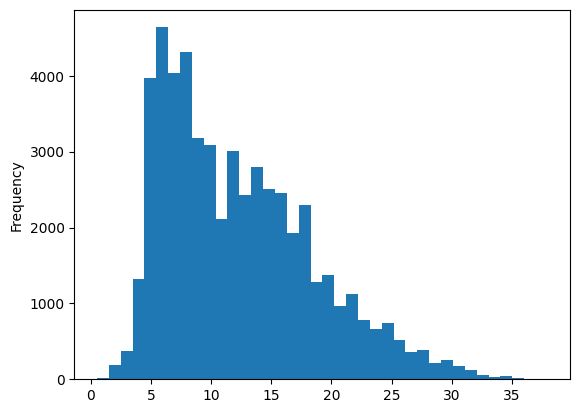

In [29]:
whole_bins = round(gdf['height'][gdf['in_qualified_cohort']].max())
gdf['height'][gdf['in_qualified_cohort']].plot.hist(bins=whole_bins)

In [30]:
trunk_diameter =       gdf[gdf['in_qualified_cohort']].groupby('trunk_diameter')['trunk_diameter'].count().index.to_list()
trunk_diameter_count = gdf[gdf['in_qualified_cohort']].groupby('trunk_diameter')['trunk_diameter'].count().to_list()
# for i in range(len(trunk_diameter_count)):
#     print(f'trunk_diameter {trunk_diameter[i]:<5} →   count {trunk_diameter_count[i]:<10}')

<Axes: ylabel='Frequency'>

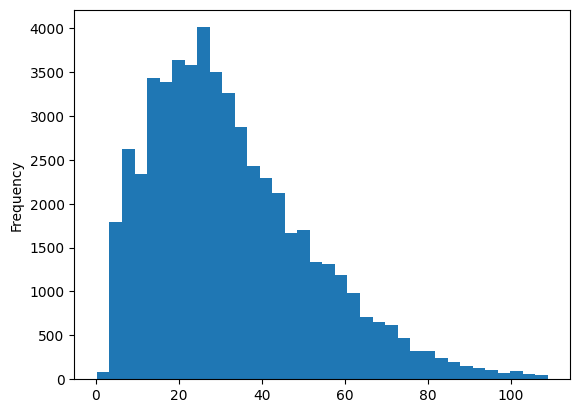

In [31]:
# Here we must divide into 3 cm bins. Instead of the nearest whole number.
whole_bins = round(gdf['trunk_diameter'][gdf['in_qualified_cohort']].max()/3)
gdf['trunk_diameter'][gdf['in_qualified_cohort']].plot.hist(bins=whole_bins)

In [32]:
trunk_circumference =       gdf[gdf['in_qualified_cohort']].groupby('trunk_circumference')['trunk_circumference'].count().index.to_list()
trunk_circumference_count = gdf[gdf['in_qualified_cohort']].groupby('trunk_circumference')['trunk_circumference'].count().to_list()
# for i in range(len(trunk_circumference_count)):
#     print(f'trunk_circumference {trunk_circumference[i]:<5} →   count {trunk_circumference_count[i]:<10}')

<Axes: ylabel='Frequency'>

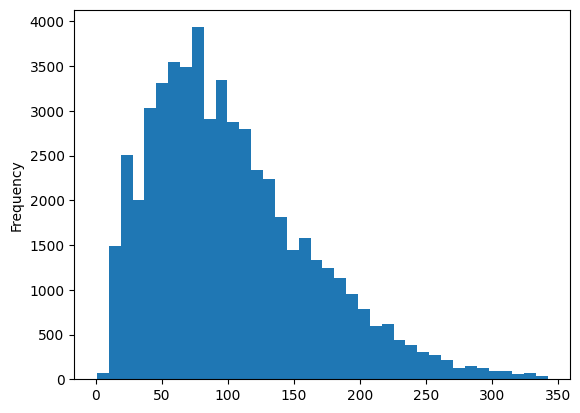

In [33]:
# here we must divide into 9 cm bins. Instead of the nearest whole number.
whole_bins = round(gdf['trunk_circumference'][gdf['in_qualified_cohort']].max()/9)
gdf['trunk_circumference'][gdf['in_qualified_cohort']].plot.hist(bins=whole_bins)

In [34]:
# generate features with gausian smoother
smother_sd = 1/2

# round height to nearest integer ...
gdf['height_standardized'] = gdf['height'].round()
# ...and apply smoother:
gdf['height_standardized'] = gdf['height_standardized'].apply(lambda x: x+ np.random.normal(loc=0, scale=smother_sd))

# round crown_diameter to nearest integer ...
gdf['crown_diameter_standardized'] = gdf['crown_diameter'].round()
# ...and apply smoother:
gdf['crown_diameter_standardized'] = gdf['crown_diameter_standardized'].apply(lambda x: x+ np.random.normal(loc=0, scale=smother_sd))

# round trunk_circumference to nearest 9th centimeter ...
gdf['trunk_circumference_standardized'] = gdf['trunk_circumference'][gdf['trunk_circumference'].notna()].apply(lambda x: round_to_nearest_n(x, base=9))
# ...and apply smoother:
gdf['trunk_circumference_standardized'] = gdf['trunk_circumference_standardized'].apply(lambda x: x+ np.random.normal(loc=0, scale=smother_sd*9))

# round trunk_diameter to nearest 3rd centimeter ...
gdf['trunk_diameter_standardized'] = gdf['trunk_diameter'][gdf['trunk_diameter'].notna()].apply(lambda x: round_to_nearest_n(x, base=3))
# ...and apply smoother:
gdf['trunk_diameter_standardized'] = gdf['trunk_diameter_standardized'].apply(lambda x: x+ np.random.normal(loc=0, scale=smother_sd*3))


array([[<Axes: xlabel='height_standardized', ylabel='height_standardized'>,
        <Axes: xlabel='trunk_diameter_standardized', ylabel='height_standardized'>,
        <Axes: xlabel='trunk_circumference_standardized', ylabel='height_standardized'>,
        <Axes: xlabel='crown_diameter_standardized', ylabel='height_standardized'>],
       [<Axes: xlabel='height_standardized', ylabel='trunk_diameter_standardized'>,
        <Axes: xlabel='trunk_diameter_standardized', ylabel='trunk_diameter_standardized'>,
        <Axes: xlabel='trunk_circumference_standardized', ylabel='trunk_diameter_standardized'>,
        <Axes: xlabel='crown_diameter_standardized', ylabel='trunk_diameter_standardized'>],
       [<Axes: xlabel='height_standardized', ylabel='trunk_circumference_standardized'>,
        <Axes: xlabel='trunk_diameter_standardized', ylabel='trunk_circumference_standardized'>,
        <Axes: xlabel='trunk_circumference_standardized', ylabel='trunk_circumference_standardized'>,
        <Axe

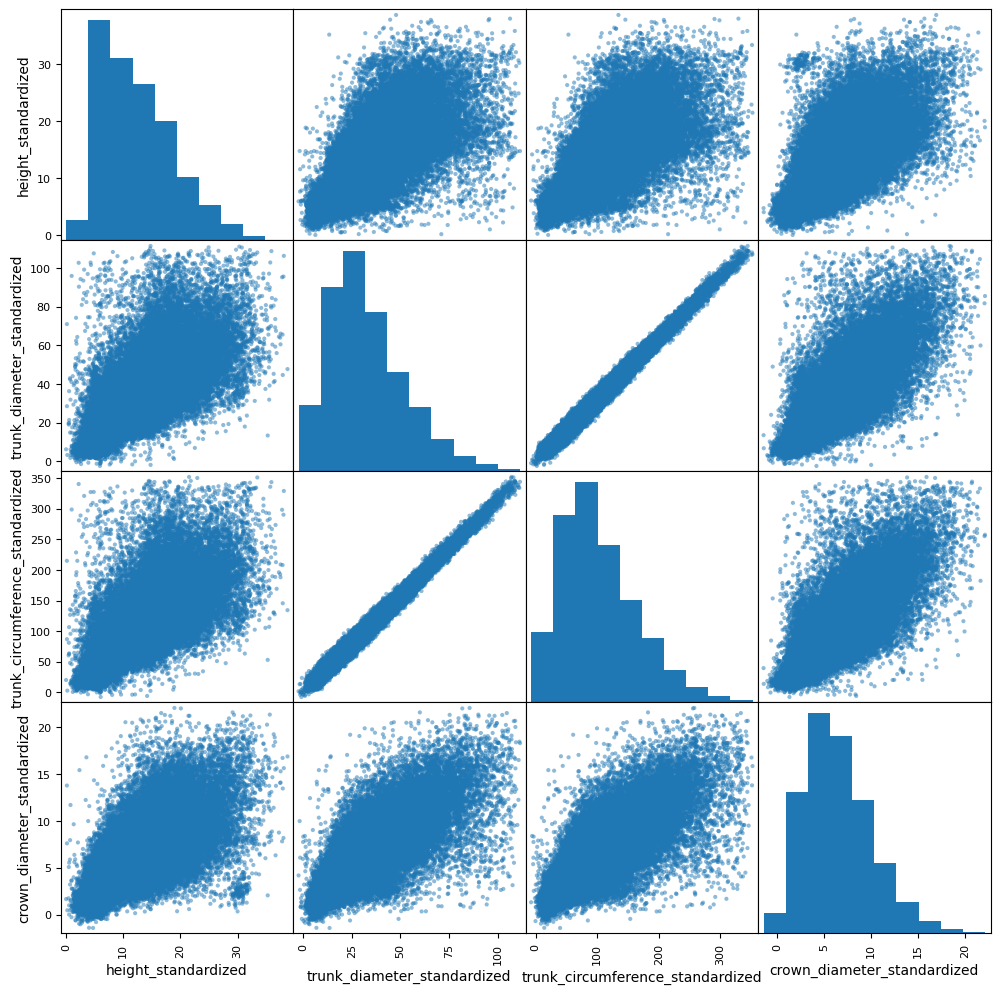

In [35]:
# revisit matrix plot of qualified subset
# with observational methodology standardized.
data_subset = gdf[['height_standardized','trunk_diameter_standardized','trunk_circumference_standardized','crown_diameter_standardized']][gdf['in_qualified_cohort']]
scatter_matrix(data_subset, figsize=(12,12))

In [36]:
# generate baseline abstraction feature: volume
gdf['volume'] = gdf['height_standardized'] * (math.pi*((gdf['crown_diameter_standardized']/2)**2))
# generate baseline abstraction feature: cover_area
gdf['cover_area'] = (math.pi*((gdf['crown_diameter_standardized']/2)**2))

<Axes: title={'center': 'Tilia tomentosa'}, xlabel='trunk_circumference_standardized', ylabel='volume'>

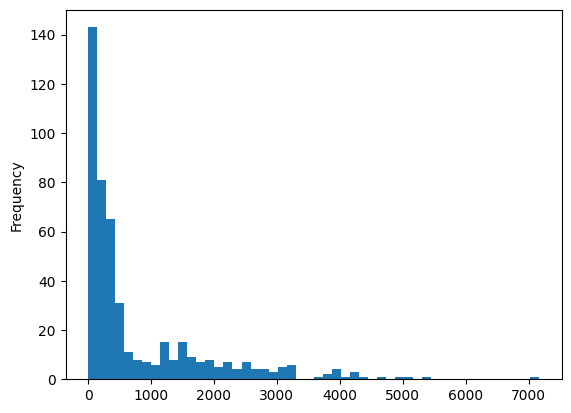

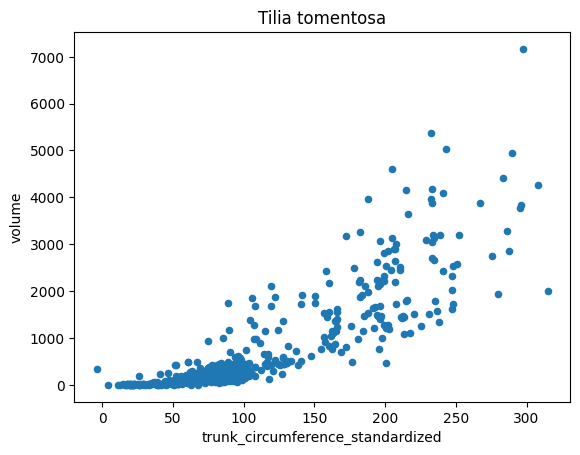

In [37]:
# sample per species metrics from qualified subset with abstraction
rand_species = random.choice(valid_species)
gdf.loc[gdf['botanical_species_formal_name'] == rand_species, 'volume'][gdf['in_qualified_cohort']].plot.hist(bins=50)

# Here we begin to see patters of exponetial decay
# This suggests there is a replacement rate that needs to be taken into account.

gdf.loc[(gdf['botanical_species_formal_name'] == rand_species) & (gdf['in_qualified_cohort'])]\
    .plot(kind='scatter', x='trunk_circumference_standardized', y='volume', title=f'{rand_species}')

# Trunk diameter is not absolute measure of age.
# It is a solid measurement relative to a species within a constrained environment.
# We see that volume is somewhat age dependent.
# Accelerating as a tree ages.

# We can fit a confidence interval to these plots suggesting maxumum upper and lower volumes.
# I suspect that these upper and lower bounds have much to do with competitive density.

Text(0.5, 1.02, 'Species = Prunus domestica.\nn = 150')

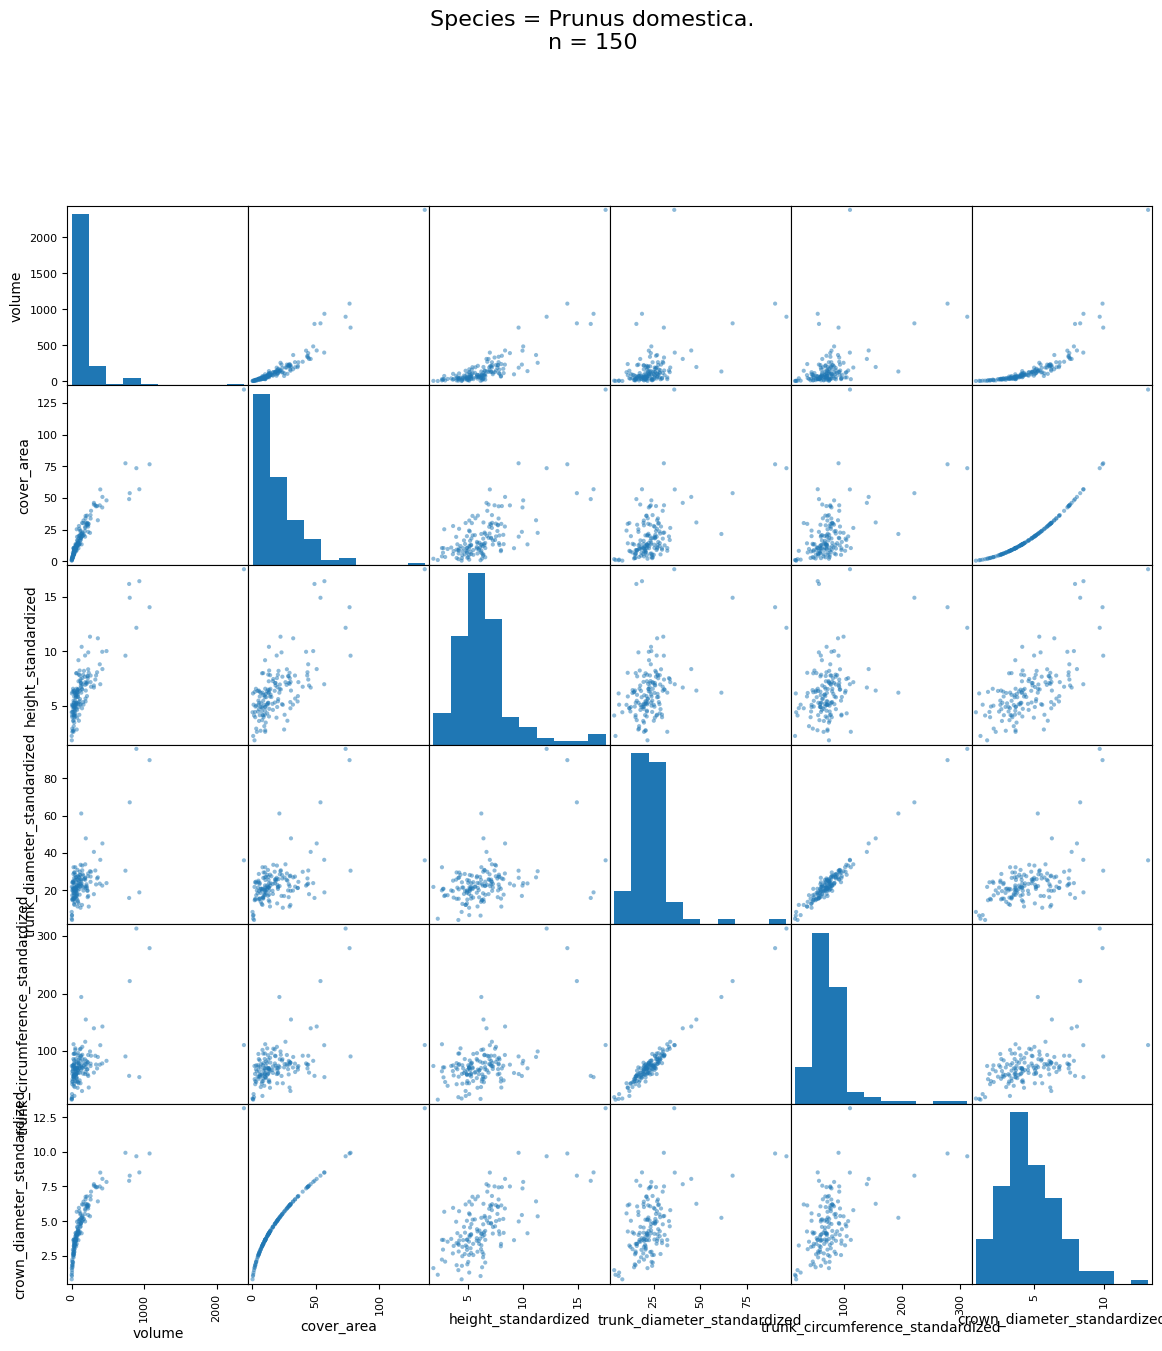

In [38]:
# matrix by species
rand_species = random.choice(valid_species)
# print(f'Species = {rand_species}.\nn = {gdf[gdf['botanical_species_formal_name'] == rand_species].shape[0]}')
data_subset = gdf[['volume','cover_area','height_standardized','trunk_diameter_standardized','trunk_circumference_standardized','crown_diameter_standardized']]\
    [(gdf['botanical_species_formal_name'] == rand_species) & (gdf['in_qualified_cohort'])]
scatter_matrix(data_subset, figsize=(14,14), )
plt.suptitle(f'Species = {rand_species}.\nn = {gdf[gdf['botanical_species_formal_name'] == rand_species].shape[0]}', fontsize=16, y=1.02)

# This strengthens my suspicion of a unique per species contribution

Sample size = 91:


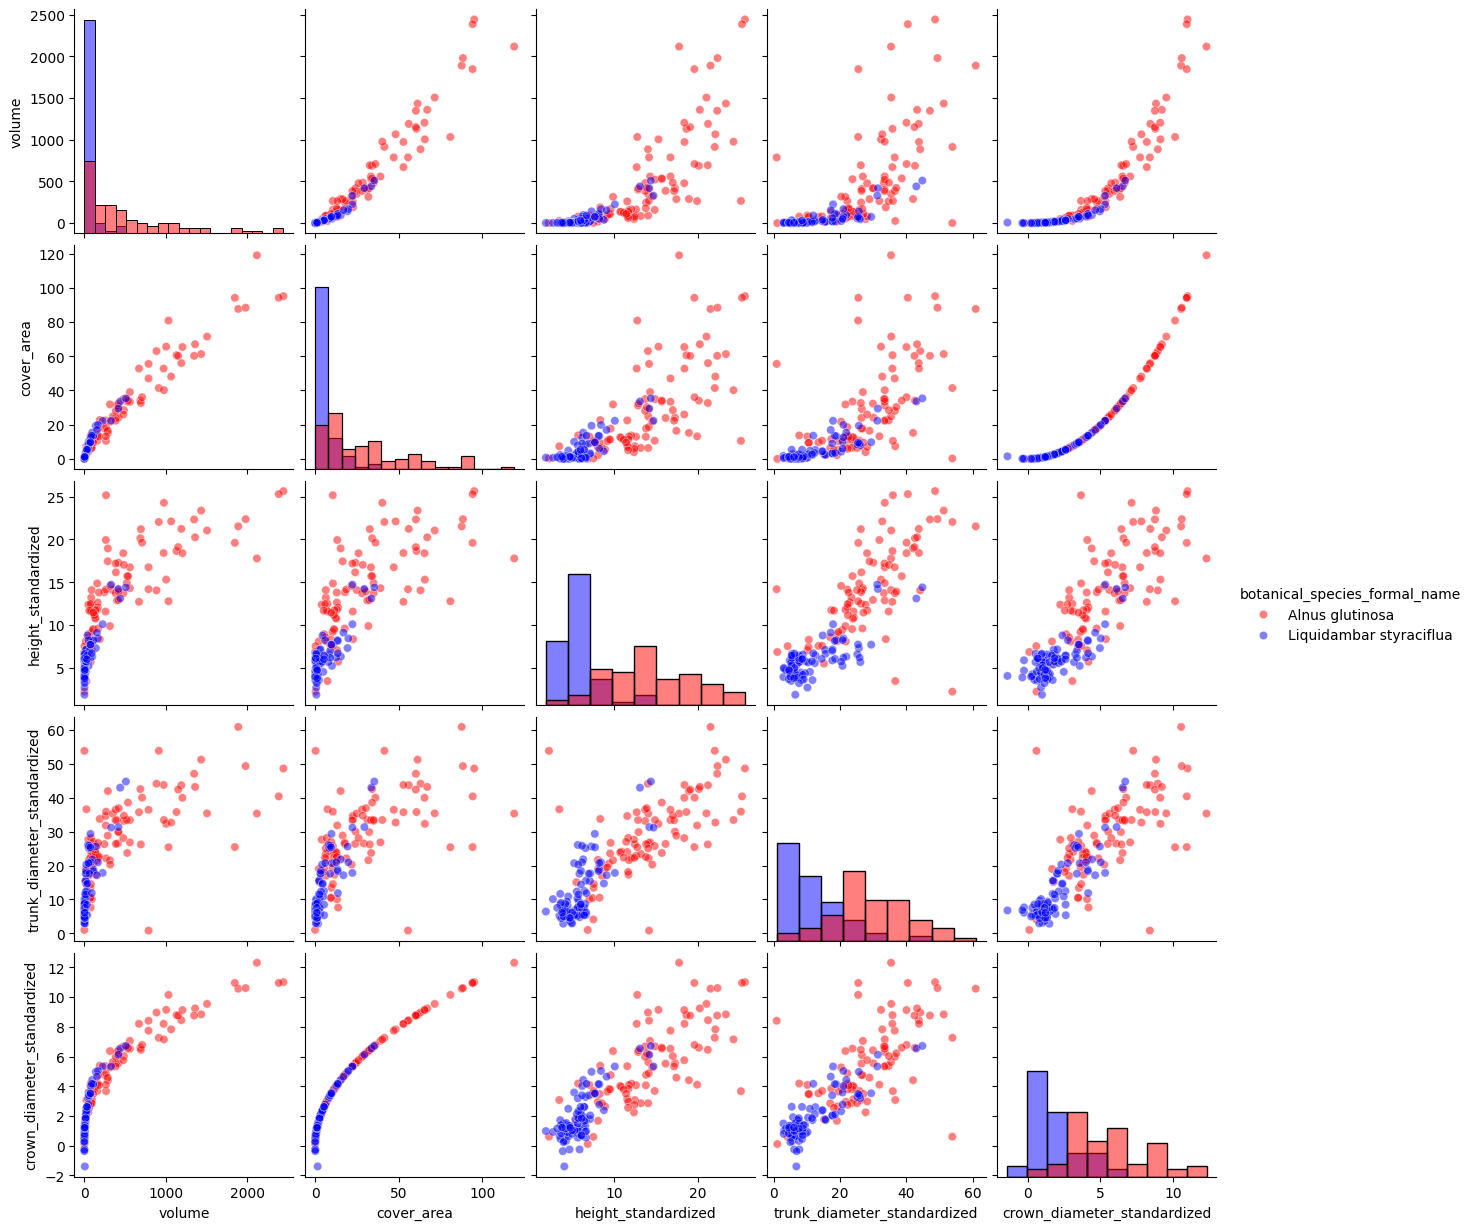

In [43]:
# matrix by species - comparison

## randomly select two valid species
rand_species_A = random.choice(valid_species)
rand_species_B = random.choice(valid_species)

# subset by species A
subset_A_with_labels = gdf.loc[(gdf['botanical_species_formal_name'] == rand_species_A) & 
                             (gdf['in_qualified_cohort']), 
                             ['botanical_species_formal_name', 'volume','cover_area','height_standardized', 
                              'trunk_diameter_standardized','crown_diameter_standardized']]

# subset by species B
subset_B_with_labels = gdf.loc[(gdf['botanical_species_formal_name'] == rand_species_B) & 
                             (gdf['in_qualified_cohort']), 
                             ['botanical_species_formal_name', 'volume','cover_area','height_standardized', 
                              'trunk_diameter_standardized','crown_diameter_standardized']]

# sample from each species 70% of the size of the smallest population
sizeA = subset_A_with_labels.shape[0]
sizeB = subset_B_with_labels.shape[0]
size = [sizeA if sizeA <= sizeB else sizeB]
size = round(size[0]*.7)
print(f'Sample size = {size}:')

# join subsets (Interesting that there is no gpd.concat. gpd relies on pd.conccat)
subset_with_labels = pd.concat([subset_A_with_labels.sample(size),subset_B_with_labels.sample(size)])

# pairplot
sns.pairplot(subset_with_labels, 
             hue='botanical_species_formal_name', 
             palette={rand_species_A: 'red', rand_species_B: 'blue'},
             diag_kind='hist', # Can also use 'kde' for smooth curves
             plot_kws={'alpha': 0.5})

# This strengthens my suspicion of a unique per species contribution

In [40]:
print(rand_species_A)
print(rand_species_B)

Malus domestica
Verschiedene oder Baumart unbekannt


## Observations

### Volume vs Crown Diameter
- We see that as a species increases in volume, it's crown spread may or may not expand significantly, Affecting vertical shade cover.
- Some species are more likley than others to provide more crown diameter as their volume increases. 
- Other, are not as inclined.
- For instance, one species of tree may be inclined to grow tall and narrow, thus having an increasing volume, but not crown diameter.
- Vertical shade cover (crown diameter) to volume ratio is a relevant measure.
- See proposed formula in desmos [s99y`cbphzq]
- Formula may be nessesary to noramlize along this dimention, or for species specific characterizations
  - The closer the concave hull is to the y axis, the 'bushier' the tree is.
  - The closer it is to the x axis, the taller and narrower the tree is.
- This relationship (internal to the species) seems to be governed by some sort of gravity
  - Younger trees grow much faster than older trees?

### trunk_diameter vs trunk_circumfernece
- Nearly perfect correlation.
- These are indipendently meaningless.
- Tree trunks are (unsuprisingly) regular ellipses and diameter and circumference are very closeley related.
- However, the species-wise, and inter species comparisons are useful (These are Interval not Ratio)
  - Trees of the same species, that are in the same geogreaphic region, as in this study, can be ranked for age,
  - This tells us something about intra-speceies characteristics (hight, volume, diameter)
  - Being normal in form, it suggests a tipping point within a species, after which die off is more likely. (Survival)
- Without tree ring data, we cannot make cross species comparision with this.


### volume vs. height
- While height and crown_diameter seem to move in lock step, the same cannot be said for height and volume
- some trees get very tall, but vary little in volume.  Conniferous trees would likely follow this morphology.
- This speaks to the species specific cover value.
- certain speceies will not vary in cover reguardless of other factors.
- Other species will, and may or may not be more valuable because of it.

--- 

There are more relationships to dig into here. But other features need to be developed.
We can say that, in genreal we see distinct and sometimes seperable morphologies based on species. 
After ajusting for outliers, vanishing populations, methodological quirks, and normalizing sample size
This suggests to us that spcies specific contributions to UTC may still be a viable path of inquiry.

Next steps include working on a way to represent a competitive density and competitive diversity metric.